<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/notebook_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Projekt aus dem Github klonen und in den Projektsordner**

In [ ]:
#wenn die Ordner noch nicht geklont ist, soll dieser Fehler zuerst durchgeführt werden.
!git clone https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space.git

Cloning into 'replication-topic-modelling-in-embedding-space'...
remote: Enumerating objects: 2421, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 2421 (delta 201), reused 258 (delta 86), pack-reused 2024
Receiving objects: 100% (2421/2421), 535.00 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (1256/1256), done.


In [ ]:
cd /content/replication-topic-modelling-in-embedding-space

/content/replication-topic-modelling-in-embedding-space


# **Das Trainieren über GPU: in dem Colab-runtime, wählen GPU**
1. runtime/Laufzeit
2. change runtime type/Laufzeittyppen ändern
3. choose GPU and save/GPU auswählen und speichern

# **Die benötige Paketen für das Projekt mittels requirements.txt installieren**



In [ ]:
# Falls die Packages noch nicht installiert wurden, 
!pip install -r "/content/replication-topic-modelling-in-embedding-space/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.5 MB/s 
     |████████████████████████████████| 4.2 MB 59.1 MB/s 
     |████████████████████████████████| 88 kB 8.6 MB/s 
     |████████████████████████████████| 28.8 MB 101.6 MB/s 
     |████████████████████████████████| 636 kB 52.7 MB/s 
     |████████████████████████████████| 79.9 MB 115 kB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 56.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6ce95f2dd3c9a755a144ad0892d993e2d130586c771e420fe7b8e9001bf9d6bf
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=58b51a31787d7621de515

# **Struktur: 2 Versionen (Notebooks und Command-Lines)**

In diesem Notebook kann man zwei Versionen durchführen:

1.   durch command lines (LDA Command, ETM-Command, BERT-ETM Command)
2.   Notebook für alle Schritten nach und nach durchführen
3.   Wenn nur Notebook benutzen möchte, springen zum Teil Notebook

# **Für Notebooks**
Wenn jemand Notebooks benutzt, um alle Schritten anzuschauen, bitte überspringen den Teil, in den Command-Lines sich befinden



# **Command-Teil**

**LDA Command**
1. batch-test-size: Testdataset wird zu kleineren Batches mit batch-size-test zerlegt und dann Perplexity berechnen.
2. die *Endperplexity* ist der Durchschnitt von allen Batch-Perplexites

In [ ]:
#run main_lda.py --filter-stopwords "True" --min-df 30 --epochs 20 --use-tensor True --batch-test-size 1000

filter stopwords: True
filter stopwords: True
loading texts: ...
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





train-size after loading: 11314
test-size after loading: 7532
finished load!
start: preprocessing: ...
preprocessing step: remove stopwords
finised: preprocessing!
vocab-size in df: 8496
preprocessing remove stopw

100%|██████████| 20/20 [00:00<00:00, 49402.87it/s]

number of topics: 20
calculate perplexity:....


test-docs: from 0 to 1000
ppl of batch 1: 8.150738847141124
test-docs: from 1000 to 2000
ppl of batch 2: 8.148755636492822
test-docs: from 2000 to 3000
ppl of batch 3: 8.146552472151644
test-docs: from 3000 to 4000
ppl of batch 4: 8.133709139763923
test-docs: from 4000 to 5000
ppl of batch 5: 8.144285514676735
test-docs: from 5000 to 6000
ppl of batch 6: 8.1097638767229
test-docs: from 6000 to 7000
ppl of batch 7: 8.155350564571188
test-docs: from 7000 to 7532
ppl of batch 8: 8.170441779038889
end perplexity - show perplexity: 
e-normalized-perplexity-lda: 0.40559086629001884
calculate coherence and diversity
topic coherence 0.17668937635583054
topic diversity 0.754
ending coherence and diversity


**Skipgram-ETM**

1. epochs
2. wordvec-model: skipgram oder cbow
3. min-df
4. filter-stopwords: "True"/"False" as String
5. activate-func: "ReLU" oder "tanh"
6. hidden-size: 
7. optimizer-name: "adam" oder "sgd"
8. learing rate: lr
9. weight-decay wdecay

In [ ]:
#run main.py --model "ETM" --epochs 150 --wordvec-model "skipgram" --loss-name "cross-entropy" --min-df 100 --num-topics 20 --filter-stopwords "True" --hidden-size 800 --activate-func "ReLU" --optimizer-name "adam" --lr 0.002 --wdecay 0.0000012

**BERT-ETM Command**
1. für Bert nur in dem Fall, dass Datensaz ohne Stopwörter ist das Durchführen möglich
2. Experiment mit BERT: bitte herunterladen die Bert-Embedding-File **bert_vocab_embedding.txt** zuerst und packen in dem Ordner: **prepared_data/** (siehe READme)

In [ ]:
#run main.py --model "ETM" --epochs 2 --wordvec-model "bert" --loss-name "cross-entropy" --min-df 10 --num-topics 20 --filter-stopwords "True" --hidden-size 800 --activate-func "ReLU" --optimizer-name "adam" --lr 0.002 --wdecay 0.0000012

using cuda: False
filter-stopwords: True
----------------------------------------------------------------------------------------------------


loading texts: ...
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





train-size after loading: 11314
test-size after loading: 7532
finished load!
start: preprocessing: ...
preprocessin

iter over bert-vocab:   0%|          | 84/104008 [00:00<02:04, 837.68it/s]

bert-reading finished
update bert by given vocab


iter over bert-vocab: 100%|██████████| 104008/104008 [01:27<00:00, 1185.24it/s]


example 5 element of word-vector: [-0.29880613 -2.86340356 -0.14214839 -1.84090602  3.61773515]
ETM initilize...
--------------------------------------------------MODEL-SUMMARY--------------------------------------------------
ETM(
  (theta_act): ReLU()
  (topic_embeddings_alphas): Linear(in_features=768, out_features=20, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=18637, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=20, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=20, bias=True)
)
--------------------------------------------------TRAIN--------------------------------------------------
number of batches: 12
Epoch: 1/2  -  Loss: 1097.84509 	 Rec: 1097.45032 	 KL: 0.39488
Epoch: 2/2  -  Loss: 1036.34802 	 Rec: 1035.17322 	 KL: 1.17482
Checkpoint saved at checkpoints/etm_epoch_2.pth.tar


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

100%|██████████| 20/20 [00:00<00:00, 138425.87it/s]


topic-coherrence: 0.09996242525380584
topic-diversity: 0.508
calculate perplexitiy of test dataset: ...
test-1-loader: 7
test-2-loader: 7
batch 0 finished
batch 1 finished
batch 2 finished
batch 3 finished
batch 4 finished
batch 5 finished
batch 6 finished
topic-normalized-perplexity: 0.5014701937007029


# **Notebooks für alle Schritten: LDA und ETM**

1. Da der Umfang der Implementierung ziemlich große ist, wird die Implementierung für unterschiedliche Komponenten in dem Ordner `src` gespeichert [hier:](https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space/tree/main/src)

2. Die gebrachten Komponenten werden in diesem Notebook dann importieren und die Ausgaben werden angezeigt.



# **Gebrauchte Paketen importieren**

In [ ]:
# einige Paketten wurden für Visualisierung gebraucht
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap
import time
import plotly.express as px
from sklearn import cluster
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# **Vorverarbeitung und BOW-Repräsentationen für Textdaten durchführen**
1. Vocabular erstellen
2. BOW-Repräsentationen für allen Teildatensätzen
3. Wichtige Parameters sind:


*   stopwords_filter = True/False
*   use_bert_embedding = True/False
*   min_df für unterschiedliche Vocabulargröße
*   stopwords_remove_from_vocab = True/False




In [ ]:
use_bert_embedding = False #in this notebook we do not use BERT-Embeddings
stopwords_filter = True

In [ ]:
# init TextDataLoader für die Datenquelle 20 News Groups
# Daten abrufen vom Sklearn, tokenisieren und besondere Charaktern entfernen
from src.prepare_dataset import TextDataLoader
textsloader = TextDataLoader(source="20newsgroups", train_size=None, test_size=None)
textsloader.load_tokenize_texts("20newsgroups")
textsloader.show_example_raw_texts(n_docs=2)
# Vorverarbeitung von Daten mit folgenden Schritten:
textsloader.preprocess_texts(length_one_remove=True, 
                             punctuation_lower = True, 
                             stopwords_filter = stopwords_filter,
                             use_bert_embedding = use_bert_embedding)
# Daten zerlegen für Train, Test und Validation. Erstellen Vocabular aus dem Trainset

min_df=100
textsloader.split_and_create_voca_from_trainset(max_df=0.7, 
                                                min_df=min_df, 
                                                stopwords_remove_from_voca=stopwords_filter)

loading texts: ...
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





train-size after loading: 11314
test-size after loading: 7532
finished load!
check some sample texts of the dataset after filter punctuation and digits
['From', ':', 'lerxst', '@', 'wam', '.', 'umd', '.', 'edu', '(', "where's", 'my', 'thing', ')', 'Subject', 

# **LDA Model**

1. Benutzen das fertige Paket von Gensim, um die Topics mit LDA zu finden: [LDA Model GENSIM](https://radimrehurek.com/gensim/models/ldamodel.html)
2. Der Klasse textsloader hat bereits die geeignete Format für LDA vorbereitet:
* Setzen das Parameter: for_lda_model = True

In [ ]:
from src.evaluierung import topicCoherence2, topicDiversity
from src.lda import lda
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric


for_lda_model = True 
num_topics = 20

# Erstellen BOW-Repräsentation für LDA Model
if for_lda_model == True:
    word2id, id2word, train_set, test_set, val_set, test_set_h1, test_set_h2 = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)
    gensim_corpus_train_set = train_set
else:
    print('for_lda_model is True but still here?')
    word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)

docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
#lda model
print(100*"-")

save docs in txt...
save docs finished
train-size-after-all: 11214
test-size-after-all: 7532
validation-size-after-all: 100
test-size-after-all: 11214
test-indices-length: 11214
test-size-after-all: 100
test-indices-length: 100
test-size-after-all: 7532
test-indices-length: 7532
length train-documents-indices : 896087
length of the vocabulary: 3102


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

compact representation for LDA
save docs in txt...
save docs finished
----------------------------------------------------------------------------------------------------


In [ ]:
#ldamodel = lda(train_set,10,id2word)
ldamodel = LdaModel(train_set, 
                    num_topics= num_topics,
                    id2word = id2word, 
                    passes = 5,
                    random_state = 42)

In [ ]:
lda_topics = ldamodel.show_topics(num_topics = 20, num_words=10)
topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in lda_topics:
    topics.append(preprocess_string(topic[1], filters))
for topic in topics:
  print(topic)

['windows', 'file', 'dos', 'graphics', 'software', 'pc', 'system', 'files', 'ftp', 'program']
['god', 'people', 'jesus', 'christian', 'bible', 'life', 'church', 'christ', 'christians', 'time']
['writes', 'article', 'cs', 'university', 'colorado', 'posting', 'cc', 'nntp', 'host', 'science']
['ca', 'uk', 'ac', 'writes', 'article', 'org', 'posting', 'nntp', 'host', 'mit']
['drive', 'sale', 'scsi', 'disk', 'hp', 'hard', 'drives', 'system', 'ide', 'computer']
['window', 'information', 'data', 'application', 'source', 'time', 'widget', 'set', 'include', 'list']
['brian', 'indiana', 'gatech', 'apple', 'article', 'ucs', 'writes', 'georgia', 'sandvik', 'kent']
['university', 'posting', 'host', 'nntp', 'de', 'au', 'computer', 'writes', 'article', 'distribution']
['money', 'people', 'time', 'car', 'make', 'pay', 'work', 'year', 'list', 'good']
['power', 'state', 'ohio', 'back', 'acs', 'time', 'ground', 'home', 'work', 'left']
['andrew', 'cmu', 'washington', 'att', 'posting', 'ibm', 'host', 'nntp'

In [ ]:
tc = topicCoherence2(topics,len(topics),docs_tr,len(docs_tr))
td = topicDiversity(topics)
print(f'topic-coherrence: {tc}')
print(f'topic-diversity: {td}')

topic-coherrence: 0.18777587945253085
topic-diversity: 0.74


**Perplexity for LDA**

In [ ]:
from src.evaluierung import topicPerplexityTeil1, topicPerplexityNew
from src.utils_perplexity import get_theta_from_lda, get_beta_from_lda
import gensim
vocab = list(id2word.values())
vocab_size=len(vocab)
# get beta and theta
beta_KV = get_beta_from_lda(ldamodel, num_topics, vocab, vocab_size)
theta_test_1_DK = get_theta_from_lda(ldamodel, num_topics, test_set_h1)
n_test_docs_2 = len(test_set_h2)
test_set_h2_in_bow_sparse_matrix = gensim.matutils.corpus2csc(test_set_h2).transpose()

In [ ]:
#covert to tensor
import math
import torch
import numpy as np

ppl_over_batches = []
batch_test_size = 1000
beta_KV = torch.from_numpy(np.array(beta_KV))
i = 0
j = 0
while i <= n_test_docs_2:
    if (i+batch_test_size) <= n_test_docs_2:
        theta_test_1_batch = torch.tensor(theta_test_1_DK[i:i+batch_test_size])
        bows_test_2_batch = torch.from_numpy(test_set_h2_in_bow_sparse_matrix[i:i+batch_test_size].toarray())
    else:
       
        theta_test_1_batch = torch.tensor(theta_test_1_DK[i:])
        bows_test_2_batch = torch.from_numpy(test_set_h2_in_bow_sparse_matrix[i:].toarray())

    avg_ppl = topicPerplexityNew(theta_test_1_batch, bows_test_2_batch, vocab_size, beta_KV)
    print(f'ppl of batch {j+1}: {avg_ppl}')
    ppl_over_batches.append(avg_ppl)
    i = i + batch_test_size
    j += 1
avg_over_batches = (sum(ppl_over_batches)/len(ppl_over_batches))
ppl_total = round(math.exp(avg_over_batches),1)
normalized_ppl = ppl_total/vocab_size

print(f'end perplexity - show perplexity: ')
print(f'e-normalized-perplexity-lda: {normalized_ppl}')
ldamodel.clear()

ppl of batch 1: 7.4626675565497775
ppl of batch 2: 7.459199193874847
ppl of batch 3: 7.4777010005196125
ppl of batch 4: 7.472666592536151
ppl of batch 5: 7.489781073904341
ppl of batch 6: 7.457684657228188
ppl of batch 7: 7.48213299047086
ppl of batch 8: 7.471542143482913
end perplexity - show perplexity: 
e-normalized-perplexity-lda: 0.5665699548678272


In [ ]:
del test_set_h2
del test_set_h1
del test_set_h2_in_bow_sparse_matrix
del theta_test_1_DK
del beta_KV
del ppl_over_batches
del batch_test_size

# **Alle Schritten im Experiment mit dem ETM-Modell**

# **Daten für ETM**



1.   Input Daten für der ersten Teil ETM ist (normalisierte)Bag-Of-Words-Repräsentation

    *   for_lda_model = False

2.   textsloader.create_bow_and_savebow_for_each_set(for_lda_model=True) stellt die folgenden Daten für das Modell:

    *   word2id
    *   id2word
    *   train_set, test_set, val_set in der Form von BoW

In [ ]:
# Erstellen BOW-Repräsentation für ETM Modell
for_lda_model = False
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)

save docs in txt...
save docs finished
train-size-after-all: 11214
test-size-after-all: 7532
validation-size-after-all: 100
test-size-after-all: 11214
test-indices-length: 11214
test-size-after-all: 100
test-indices-length: 100
test-size-after-all: 7532
test-indices-length: 7532
length train-documents-indices : 896087
length of the vocabulary: 3102


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!



**Vocabular und IDs anzeigen als Beispiel**

---





In [ ]:
# show for samples: 100 word2id and id2 word
word2id_df_sample = pd.DataFrame()
word2id_df_sample['word'] = list(word2id.keys())[:20]
word2id_df_sample['id'] = list(word2id.values())[:20]
word2id_df_sample

,word,id
0,totally,0
1,top,1
2,claim,2
3,helping,3
4,purdue,4
5,conduct,5
6,implies,6
7,solutions,7
8,affect,8
9,multi,9


**Die Größe von Datensätzen kontrollieren**

In [ ]:
# Kontrollieren die Größen von verschiedenen Datensätzen
print(f'Size of the vocabulary after prprocessing ist: {len(textsloader.vocabulary)}')
print(f'Size of train set: {len(train_set["tokens"])}')
print(f'Size of val set: {len(val_set["tokens"])}')
print(f'Size of test set: {len(test_set["test"]["tokens"])}')

Size of the vocabulary after prprocessing ist: 3102
Size of train set: 11214
Size of val set: 100
Size of test set: 7532


# **Word-Embedding: Word2Vec mit Skipgramm/CBOW**

**Dokumenten wiederstellen für Word2Vec Embedding**



1.   Da wir Embeddings für jedes Wort des Vocabulares (das Vocab nur aus dem Trainset) trainieren möchten, brauchen die Train_set (Dokumenten in Wörtern)
2.   Wir trainieren Wort-Embedding für jedes Wort mit Skipgram Methode (die Autoren benutzten Skipgram. Sie stellen nur über CBOW in dem Hintergrund vor, aber sie benutzen tatsächlich Skipgram)
3.   Trainierensetting = Word2Vec (siehe [Word2Vec-Tomas Mikolov](https://arxiv.org/pdf/1310.4546.pdf))



In [ ]:
# re-erstellen von Dokumenten nach der Vorverarbeitungen. Die Dokumenten sind in Wörtern und werden für Word-Embedding Training benutzt
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
train_docs_df = pd.DataFrame()
train_docs_df['text-after-preprocessing'] = [' '.join(doc) for doc in docs_tr[:100]]
train_docs_df

save docs in txt...
save docs finished


,text-after-preprocessing
0,jackson defense nntp posting host university i...
1,apollo hp red police state usa nntp posting ho...
2,dartmouth brian hughes installing ram quadra r...
3,bu boston university physics department articl...
4,king eng umd doug computer design lab maryland...
...,...
95,physics ca pc windows os unix reply physics ca...
96,ncr jim parts information distribution world n...
97,sera zuma serdar argic nazi germany armenians ...
98,chips astro temple bible research temple unive...


**Word-Embedding trainieren mit dem Traindatensatz und gespeichert für ETM später**

Wichtige Parameters sind:


1.   model_name = "skipgram"/"cbow"/"bert"



In [ ]:
save_path = Path.joinpath(Path.cwd(), f'prepared_data/min_df_{min_df}')
figures_path = Path.joinpath(Path.cwd(), f'figures/min_df_{min_df}')
Path(save_path).mkdir(parents=True, exist_ok=True)
Path(figures_path).mkdir(parents=True, exist_ok=True)
print(save_path)

vocab = list(word2id.keys())
model_name = "skipgram"

/content/replication-topic-modelling-in-embedding-space/prepared_data/min_df_100


In [ ]:
from src.embedding import WordEmbeddingCreator
from pathlib import Path

if model_name != "bert" and use_bert_embedding == False:
  wb_creator = WordEmbeddingCreator(model_name=model_name, documents = docs_tr, save_path= save_path)
  wb_creator.train(min_count=0, embedding_size= 300)
  wb_creator.create_and_save_vocab_embedding(vocab, save_path)
else:
  print('festlegen welches Modell für word2vec soll genutzt werden!\n Wenn bert-Modell, bitte die Vocabular aktualisieren durch use_bert_embedding = True')


train word-embedding with skipgram
length of vocabulary from word-embedding with skipgram: 3102
length of vocabulary after creating BOW: 3102


100%|██████████| 3102/3102 [00:00<00:00, 5894.95it/s]


**Visualierung von Wortembeddings mit UMAP (UMAP werden die Embeddings zu 2D reduziert. KMeans wurden benutzen, um zu sehen, wie die Clusters von Wörtern aussehen - nur zu sehen, nicht zu dem Paper gehören)**

- Dieses Experiment gehört nicht zum Artikel, der repliziert wurde

In [ ]:
if model_name != "bert" and use_bert_embedding == False:
  wb_creator.cluster_words(save_path, figures_path, n_components=2, text = False)
else:
  print('festlegen welches Modell für word2vec soll genutzt werden!\n Wenn bert-Modell, bitte die Vocabular aktualisieren durch use_bert_embedding = True')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


#**Testen ein paar Word-Embeddings and ähnliche semantische Wörter**

In [ ]:
if model_name != "bert" and use_bert_embedding == False:
  v = list(wb_creator.model.wv.vocab)[0]
  vec = list(wb_creator.model.wv.__getitem__(v))
  print(f'{model_name} word-embedding of the word: {v}')
  print(f'some elements of vector: {vec[:5]}')
  print(f'total dim of vector: {len(vec)}')
  print(f'show some semantic similar words \n')
  for i in range(5,10):
      print(f'neighbors of word: {vocab[i]}')
      print([r[0] for r in wb_creator.find_most_similar_words(n_neighbor=5, word=vocab[i])])
      print([r[1] for r in wb_creator.find_most_similar_words(n_neighbor=5, word=vocab[i])])
      print(100*"-")
else:
  print('festlegen welches Modell für word2vec soll genutzt werden!\n Wenn bert-Modell, bitte die Vocabular aktualisieren durch use_bert_embedding = True')

skipgram word-embedding of the word: jackson
some elements of vector: [-0.0064425697, 0.05336388, -0.0791205, 0.14298755, 0.01092479]
total dim of vector: 300
show some semantic similar words 

neighbors of word: conduct
['establish', 'interests', 'grounds', 'measures', 'economic']
[0.8785027861595154, 0.8771042227745056, 0.8538452982902527, 0.8492910265922546, 0.8467714786529541]
----------------------------------------------------------------------------------------------------
neighbors of word: implies
['deny', 'irrelevant', 'imply', 'justification', 'arguing']
[0.8767746090888977, 0.8689412474632263, 0.8676267266273499, 0.8623065948486328, 0.861356258392334]
----------------------------------------------------------------------------------------------------
neighbors of word: solutions
['tool', 'tools', 'machines', 'platform', 'bug']
[0.580713152885437, 0.5781648755073547, 0.5764162540435791, 0.5697091817855835, 0.5674580335617065]
-------------------------------------------------

# **Wenn Bert-Embedding benutzt wurde: BERT-Embedding**
1. Bert-Embedding wurde in einem anderen Prozess durchgeführt
2. Um Bert-Durchführen zu können, bitte herunterladen diesen Daten: `bert_vocab_embedding.txt`,und in den richtigen Order einpacken, konvertiern mittels `src/bert_covert_format.py`, wie im dem READme beschrieben wurde. 
2. Bert-Embedding wurde in dem `prepared_data/bert_vocab_embedding.txt` gespeichert
3. Um Bert-Embedding verwendet, muss man im Vorfield folgende Punkten achten:

*   Bei der Vorbereitung von Daten muss folgende Argument setzen: use_bert_embedding = True
*   model_name = "bert" setzen




In [ ]:
#run bert_main.py
#dieser Teil wegen der Laufzeit werden separat durchgeführt. Die Vocab-Embeddings wurde gespeichert und kann geladen und benutzt.
#bert_vocab_embedding.txt in prepared_data
if model_name == "bert" and use_bert_embedding == True:
  from src.embedding import BertEmbedding
  bert_eb = BertEmbedding('prepared_data') #directory, where the txt.file of bert_vocab_embedding.txt ist
  try:
    bert_eb.get_bert_embeddings(vocab)
    print(bert_eb.bert_embeddings.shape)
  except:
    print("musst bert_main.py lokal durchgeführt werden, um die Bert-Embedding für Vocabular zu erstellen. \n")
    print("die Embedding wird erst danach durch bert_main.py in dem Ordner prepared_data\bert_vocab_embedding.txt' gespeichert")

# **ETM Model und ETM Trainieren**

ETM hat die ähnliche Architektur eines Variational Autoencoders (Encoder für Sampling latent Repräsentation von Dokument) und (Decoder: eigenlich nur das Produkt von doc-over-topics und topic-over-vocabulary)

ETM wird mit den pretrainierten Embedding kombiniert. Die Embeddings für Topics werden als Gewichten eines Teiles des Netzes aktualiert mittels der negative-ELBO (Reconstruction-Loss + KLD Loss)


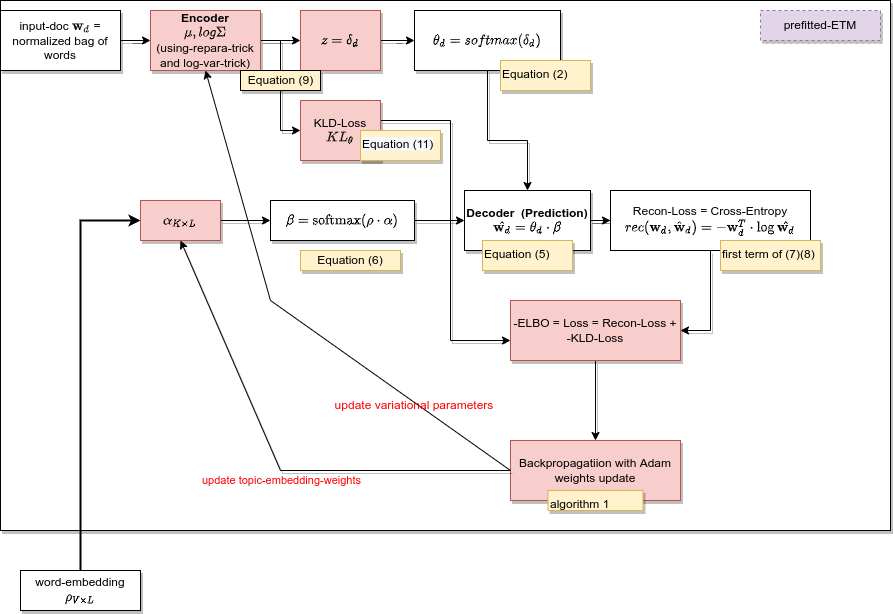



**kontrollieren die Inputdaten DocSet**
1. Diese Klasse `DocSet` wurde implementiert, damit die Daten effizienter mit Pytorch geladen innerhalb des Batches werden können
2. `tr_set.__getitem__(0`) return die Repräsentation für das Dokument 0. Wegen der Normalisierung - die Summe = `0.9999997615814209`






In [ ]:
# using DocSet to use easier the modul DataSet from torch
from src.train_etm import DocSet, TrainETM
from src.etm import ETM
import torch

vocab_size = len(list(word2id.keys()))
tr_set = DocSet("train", vocab_size, train_set, normalize_data=True)
print(f'total train docs: {len(tr_set)}')
print(f'sum of vector: {sum(tr_set.__getitem__(0)["normalized"])}')
print(f'length of vector: {torch.norm(tr_set.__getitem__(0)["normalized"])}')

total train docs: 11214
sum of vector: 1.0000003576278687
length of vector: 0.1649533212184906


**Prefitted-Embeddings einlesen**

In [ ]:
# read embedding 
from src.embedding import read_prefitted_embedding
_, embedding_data = read_prefitted_embedding(model_name, vocab, save_path)

start reading lines embeddings file:...


reading word-embedding...: 100%|██████████| 3102/3102 [00:00<00:00, 9954.79it/s] 

end reading lines embeddings file!


**Trainingsparametern vorbereiten**




In [ ]:
epochs = 150
batch_size = 1000
lr = 0.002
wdecay = 0.0000012
num_topics = 20
t_hidden_size = 8
theta_act = "tanh"

In [ ]:
class TrainArguments:
      def __init__(self, epochs, batch_size, log_interval):
          self.epochs = epochs
          self.batch_size = batch_size
          self.log_interval = log_interval

class OptimizerArguments:
      def __init__(self, optimizer_name, lr, wdecay):
            self.optimizer = optimizer_name
            self.lr = lr
            self.wdecay = wdecay


train_args = TrainArguments(epochs=epochs, batch_size=batch_size, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=lr, wdecay=wdecay)
print(train_args.epochs)
print(optimizer_args.optimizer)
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])

150
adam


# **ETM mit Cross-Entropy**

1.   ETM-initialisieren
2.   Trainieren das ETM-Modell mit den Training-Settings-Parameters


**Aktivierte Funktion: Tanh**

ETM(
  (theta_act): Tanh()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=20, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=3102, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
  )
  (mu_q_theta): Linear(in_features=8, out_features=20, bias=True)
  (logsigma_q_theta): Linear(in_features=8, out_features=20, bias=True)
)
number of batches: 12
Epoch: 1/150  -  Loss: 641.94141 	 Rec: 641.33563 	 KL: 0.60583
Epoch: 2/150  -  Loss: 641.37244 	 Rec: 641.03174 	 KL: 0.3407
Epoch: 3/150  -  Loss: 633.64502 	 Rec: 633.46173 	 KL: 0.18331
Epoch: 4/150  -  Loss: 629.30756 	 Rec: 629.21301 	 KL: 0.09456
Epoch: 5/150  -  Loss: 636.04968 	 Rec: 636.00208 	 KL: 0.04756
Epoch: 6/150  -  Loss: 627.70471 	 Rec: 627.68103 	 KL: 0.02362
Epoch: 7/150  -  Loss: 632.35791 	 Rec: 632.34375 	 KL: 0.01418
Epoch: 8/150  -  Loss: 632.05511 	 Rec: 632.0448 	 KL: 0.01034
Epoch: 9/150  -  Loss: 630.68201 	 Rec:

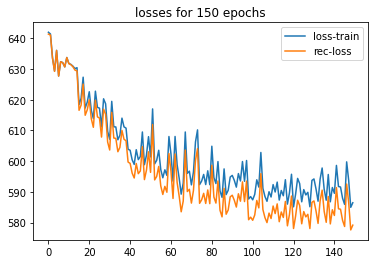

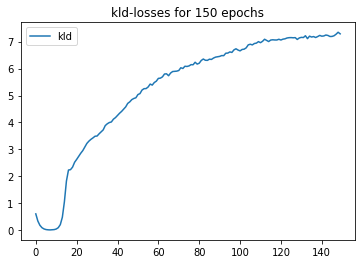

['left', 'research', 'side', 'center', 'message', 'back', 'org', 'problems', 'major', 'disclaimer']
['writes', 'host', 'ca', 'posting', 'university', 'article', 'nntp', 'mail', 'computer', 'cs']
['writes', 'article', 'posting', 'host', 'nntp', 'university', 'cs', 'reply', 'apr', 'org']
['time', 'work', 'back', 'years', 'good', 'run', 'read', 'long', 'make', 'times']
['windows', 'file', 'dos', 'drive', 'software', 'system', 'information', 'program', 'data', 'version']
['people', 'problem', 'things', 'find', 'point', 'made', 'lot', 'thing', 'big', 'good']
['space', 'key', 'nasa', 'encryption', 'clipper', 'technology', 'chip', 'keys', 'public', 'security']
['phone', 'line', 'power', 'send', 'find', 'buy', 'work', 'good', 'info', 'stuff']
['article', 'writes', 'computer', 'posting', 'case', 'wrote', 'post', 'steve', 'type', 'power']
['writes', 'article', 'state', 'world', 'john', 'man', 'day', 'love', 'news', 'david']
['car', 'speed', 'engine', 'bike', 'hp', 'high', 'cover', 'low', 'wire',

In [ ]:
#--------------------------training----------------------------------------------------
#del etm_model
# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

loss_name = "cross-entropy"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path,
    visualization = True)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
#for tp in topics:
#  print(tp)

topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)

In [ ]:
from src.evaluierung import topicCoherence2, topicDiversity
tc = topicCoherence2(topics,len(topics),docs_tr,len(docs_tr))
td = topicDiversity(topics)
print(f'etm-topic-coherrence: {tc}')
print(f'etm-topic-diversity: {td}')

etm-topic-coherrence: 0.1595585135160988
etm-topic-diversity: 0.775


In [ ]:
from src.utils_perplexity import get_perplexity
test_batch_size = 1000
_, test_ppl = get_perplexity(etm_model, test_set, vocab_size, test_batch_size)
print(f'etm-normalized-perplexity: {test_ppl}')

calculate perplexitiy of test dataset: ...
test-1-loader: 7
test-2-loader: 7
batch 0 finished
batch 1 finished
batch 2 finished
batch 3 finished
batch 4 finished
batch 5 finished
batch 6 finished
etm-normalized-perplexity: 0.9576724693745969


**Aktivierte Funktion ReLU**

In [ ]:
del etm_model
del train_class 
del train_args
del optimizer_args

start reading lines embeddings file:...


reading word-embedding...: 100%|██████████| 3102/3102 [00:00<00:00, 8653.27it/s]


end reading lines embeddings file!
ETM(
  (theta_act): ReLU()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=20, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=3102, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=20, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=20, bias=True)
)
number of batches: 12
Epoch: 1/150  -  Loss: 649.70953 	 Rec: 649.70026 	 KL: 0.00929
Epoch: 2/150  -  Loss: 643.68079 	 Rec: 643.61145 	 KL: 0.06925
Epoch: 3/150  -  Loss: 643.56934 	 Rec: 643.14886 	 KL: 0.42048
Epoch: 4/150  -  Loss: 630.76715 	 Rec: 629.49231 	 KL: 1.27488
Epoch: 5/150  -  Loss: 623.78253 	 Rec: 621.58148 	 KL: 2.2011
Epoch: 6/150  -  Loss: 628.23364 	 Rec: 625.47089 	 KL: 2.7628
Epoch: 7/150  -  Loss: 620.57849 	 Rec: 617.32025 	 KL: 3.25821
Epoch: 8/150  -  Loss: 617.84705 	 Rec: 614.32288 	 KL: 3.

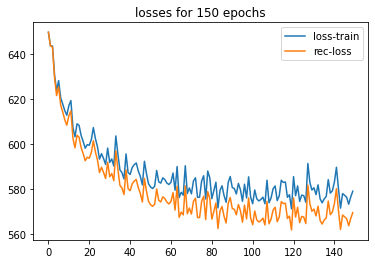

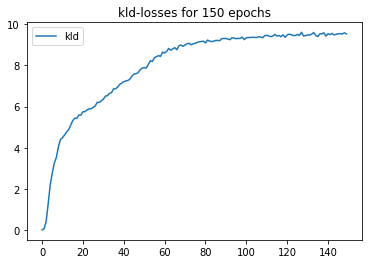

['max', 'uk', 'ac', 'de', 'au', 'tu', 'sgi', 'rz', 'wa', 'keith']
['mail', 'information', 'list', 'group', 'email', 'internet', 'info', 'send', 'ftp', 'faq']
['key', 'public', 'chip', 'clipper', 'encryption', 'government', 'law', 'keys', 'phone', 'secure']
['posting', 'host', 'nntp', 'university', 'cc', 'news', 'reply', 'apr', 'article', 'message']
['years', 'read', 'back', 'times', 'heard', 'left', 'israel', 'ago', 'history', 'told']
['cs', 'university', 'writes', 'article', 'andrew', 'uiuc', 'cmu', 'cwru', 'engineering', 'ohio']
['state', 'writes', 'article', 'distribution', 'world', 'computer', 'university', 'usa', 'netcom', 'david']
['space', 'nasa', 'gov', 'access', 'health', 'national', 'shuttle', 'billion', 'research', 'medical']
['time', 'problem', 'work', 'find', 'long', 'system', 'line', 'good', 'day', 'number']
['car', 'power', 'high', 'speed', 'front', 'bike', 'engine', 'water', 'good', 'cars']
['god', 'jesus', 'people', 'life', 'christian', 'christians', 'christianity', 'r

In [ ]:
train_args = TrainArguments(epochs=150, batch_size=1000, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.002, wdecay=0.0000012)

from src.embedding import read_prefitted_embedding
_, embedding_data = read_prefitted_embedding(model_name, vocab, save_path)

num_topics = 20
t_hidden_size = 800
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "ReLU"


etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

#--------------------------training----------------------------------------------------
loss_name = "cross-entropy"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path,
    visualization = True)
    

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)

tc = topicCoherence2(topics,len(topics),docs_tr,len(docs_tr))
td = topicDiversity(topics)
print(f'topic-coherrence: {tc}')
print(f'topic-diversity: {td}')